# Naive Bayes and logistic regression

In this practical, we will learn about [PROBABILITY DISTRIBUTIONS - TORCH.DISTRIBUTIONS](https://pytorch.org/docs/stable/distributions.html) for a simple classification problem.

In [1]:
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import torch

## Iris dataset
We will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Our goal is to construct a Naive Bayes classifier model that predicts the correct class from the sepal length and sepal width features. Under certain assumptions about this classifier model, we will explore the relation to logistic regression.

In [2]:
iris = datasets.load_iris()

In [3]:
data = iris.data[:, :2]
targets = iris.target

In [4]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, targets, test_size=0.2)

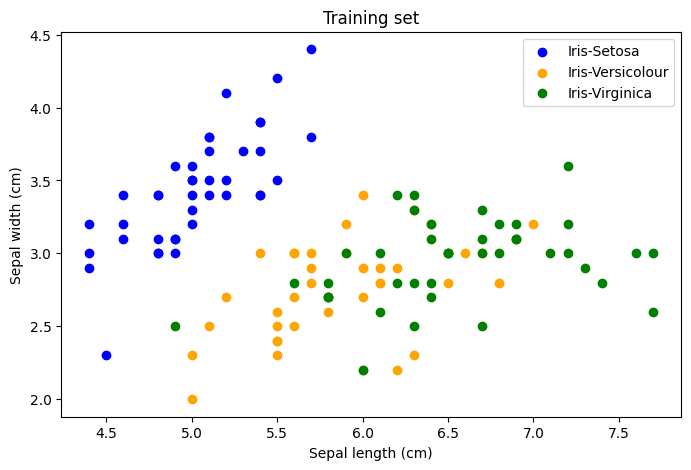

In [5]:
labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()
    
plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

## Naive Bayes classifier

We will briefly review the Naive Bayes classifier model. The fundamental equation for this classifier is Bayes' rule:

$$
P(Y=y_k | X_1,\ldots,X_d) = \frac{P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}
$$

In the above, $d$ is the number of features or dimensions in the inputs $X$ (in our case $d=2$), and $K$ is the number of classes (in our case $K=3$). The distribution $P(Y)$ is the class prior distribution, which is a discrete distribution over $K$ classes. The distribution $P(X | Y)$ is the class-conditional distribution over inputs.

The Naive Bayes classifier makes the assumption that the data features $X_i$ are conditionally independent give the class $Y$ (the 'naive' assumption). In this case, the class-conditional distribution decomposes as

$$
\begin{aligned}
P(X | Y=y_k) &= P(X_1,\ldots,X_d | Y=y_k)\\
&= \prod_{i=1}^d P(X_i | Y=y_k)
\end{aligned}
$$

This simplifying assumption means that we typically need to estimate far fewer parameters for each of the distributions $P(X_i | Y=y_k)$ instead of the full joint distribution $P(X | Y=y_k)$.

Once the class prior distribution and class-conditional densities are estimated, the Naive Bayes classifier model can then make a class prediction $\hat{Y}$ for a new data input $\tilde{X} := (\tilde{X}_1,\ldots,\tilde{X}_d)$ according to

$$
\begin{aligned}
\hat{Y} &= \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) \\
&= \text{argmax}_{y_k}\frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}\\
&= \text{argmax}_{y_k} P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)
\end{aligned}
$$



### Define the class prior distribution
 
We will begin by defining the class prior distribution. To do this we will simply take the maximum likelihood estimate, given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

where the superscript $(n)$ indicates the $n$-th dataset example, $\delta(Y^{(n)}=y_k) = 1$ if $Y^{(n)}=y_k$ and 0 otherwise, and $N$ is the total number of examples in the dataset. The above is simply the proportion of data examples belonging to class $k$.

You should now write a function that builds the prior distribution from the training data, and returns it as a [`Categorical`](https://pytorch.org/docs/stable/distributions.html#categorical) Distribution object.

* The input to your function `y` will be a numpy array of shape `(num_samples,)`
* The entries in `y` will be integer labels $k=0, 1,\ldots, K-1$
* Your function should build and return the prior distribution as a `Categorical` distribution object
  * The probabilities for this distribution will be a length-$K$ vector, with entries corresponding to $P(Y = y_k)$ for $k=0,1,\ldots,K-1$
  * Your function should work for any value of $K\ge 1$
  * This Distribution will have an empty batch shape and empty event shape

In [6]:
y_train

array([2, 2, 0, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 0, 2,
       1, 2, 2, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0,
       2, 2, 2, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 1, 0,
       2, 0, 2, 1, 2, 2, 1, 0, 2, 2])

In [7]:
from torch.distributions import Categorical

def get_prior(y):
    """
    This function takes training labels as a numpy array y of shape (num_samples,) as an input.
    """
    probs = np.unique(y, return_counts=True)[1] / len(y)
    distribution = Categorical(torch.tensor(probs))
    return distribution

In [8]:
prior = get_prior(y_train)

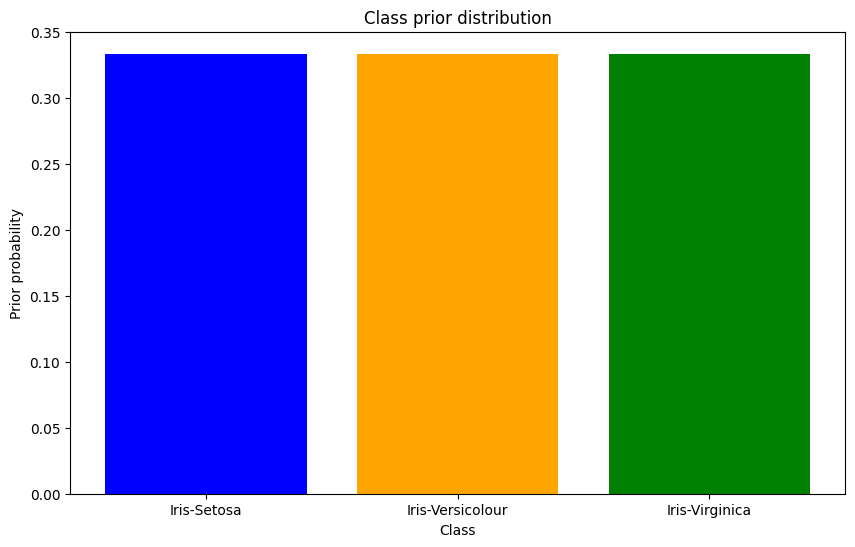

In [9]:
labels = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
plt.bar([0, 1, 2], prior.probs, color=label_colours)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

### Define the class-conditional densities

We now turn to the definition of the class-conditional distributions $P(X_i | Y=y_k)$ for $i=0, 1$ and $k=0, 1, 2$. In our model, we will assume these distributions to be univariate Gaussian:

$$
\begin{aligned}
P(X_i | Y=y_k) &= N(X_i | \mu_{ik}, \sigma_{ik})\\
&= \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x - \mu_{ik}}{\sigma_{ik}}\right)^2\right\}
\end{aligned}
$$
with mean parameters $\mu_{ik}$ and standard deviation parameters $\sigma_{ik}$, twelve parameters in all. We will again estimate these parameters using maximum likelihood. In this case, the estimates are given by

$$
\begin{aligned}
\hat{\mu}_{ik} &= \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
\hat{\sigma}^2_{ik} &= \frac{\sum_n (X_i^{(n)} - \hat{\mu}_{ik})^2 \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)}
\end{aligned}
$$

Note that the above are just the means and variances of the sample data points for each class.

You should now write a function that computes the class-conditional Gaussian densities, using the maximum likelihood parameter estimates given above.Use [`MultivariateNormal`](https://pytorch.org/docs/stable/distributions.html#multivariatenormal) abd [`Independent`](https://pytorch.org/docs/stable/distributions.html#independent)

* The inputs to the function are 
  * a numpy array `x` of shape `(num_samples, num_features)` for the data inputs
  * a numpy array `y` of shape `(num_samples,)` for the target labels
* Your function should work for any number of classes $K\ge 1$ and any number of features $d\ge 1$

In [10]:
from torch.distributions import MultivariateNormal, Independent

def get_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs.
    This function should build the class-conditional Gaussian distributions above. 
    """
    n_classes = len(np.unique(y))
    n_feat = x.shape[-1]
    #counts = np.zeros(n_classes)
    loc = np.zeros((n_classes, n_feat))
    scale_diag = np.zeros((n_classes, n_feat, n_feat))
    for i in range(n_feat):
        for c_k in range(n_classes):
            #counts[c_k] = np.sum(np.where(y==c_k))
            loc[c_k, i] = np.mean(x[np.where(y==c_k), i])
            scale_diag[c_k, i,i] = np.var(x[np.where(y==c_k), i])
    distribution = Independent(MultivariateNormal(loc=torch.tensor(loc), covariance_matrix=torch.tensor(scale_diag)),0)
    
    return distribution

In [11]:
class_conditionals = get_class_conditionals(x_train, y_train)
class_conditionals

Independent(MultivariateNormal(loc: torch.Size([3, 2]), covariance_matrix: torch.Size([3, 2, 2])), 0)

We can visualise the class-conditional densities with contour plots by running the cell below. Notice how the contours of each distribution correspond to a Gaussian distribution with diagonal covariance matrix, since the model assumes that each feature is independent given the class.

In [12]:
class_conditionals.entropy()

tensor([0.8088, 1.0110, 1.0547], dtype=torch.float64)

In [13]:
class_conditionals.log_prob(torch.randn((2)))

tensor([-212.1297, -156.1013, -169.8404], dtype=torch.float64)

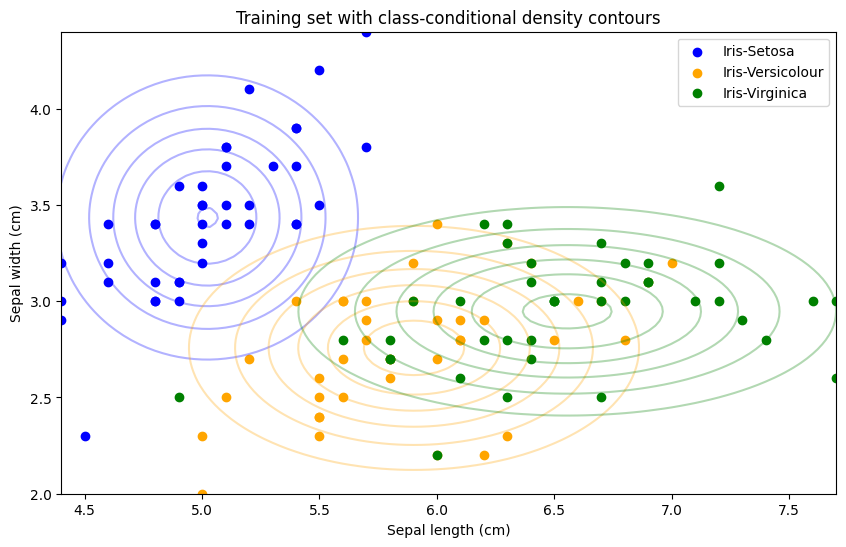

In [14]:
dtype = torch.float32
def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, logprob_fn, batch_shape, colours, levels=None, num_points=100, dtype=dtype):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = torch.exp(logprob_fn(torch.tensor(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1), dtype=dtype)))
    Z = np.array(Z.detach()).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.log_prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

### Make predictions from the model

Now the prior and class-conditional distributions are defined, you can use them to compute the model's class probability predictions for an unknown test input $\tilde{X} = (\tilde{X}_1,\ldots,\tilde{X}_d)$, according to

$$
P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) = \frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}
$$

The class prediction can then be taken as the class with the maximum probability:

$$
\hat{Y} = \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d)
$$

You should now write a function to return the model's class probabilities for a given batch of test inputs of shape `(batch_shape, 2)`, where the `batch_shape` has rank at least one. 

* The inputs to the function are the `prior` and `class_conditionals` distributions, and the inputs `x`
* Your function should use these distributions to compute the probabilities for each class $k$ as above
  * As before, your function should work for any number of classes $K\ge 1$
* It should then compute the prediction by taking the class with the highest probability
* The predictions should be returned in a numpy array of shape `(batch_shape)`

Use [`torch.logsumexp`](https://pytorch.org/docs/stable/generated/torch.logsumexp.html)

In [15]:
def predict_class(prior, class_conditionals, x):
    """
    This function takes the prior distribution, class-conditional distribution, and 
    a batch of inputs in a numpy array of shape (batch_shape, 2).
    This function should compute the class probabilities for each input in the batch, using
    the prior and class-conditional distributions, according to the above equation.
    """
    class_probs = class_conditionals.log_prob(x[:, None])
    joint_likelihood = class_probs + torch.log(prior.probs).unsqueeze(0)
    norm_factor = torch.logsumexp(joint_likelihood, dim=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    y = torch.argmax(torch.exp(log_prob), dim=-1)
    return y

In [16]:
predictions = predict_class(prior, class_conditionals, torch.tensor(x_test))
predictions

tensor([2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2,
        2, 1, 0, 2, 1, 1])

In [17]:
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.7333


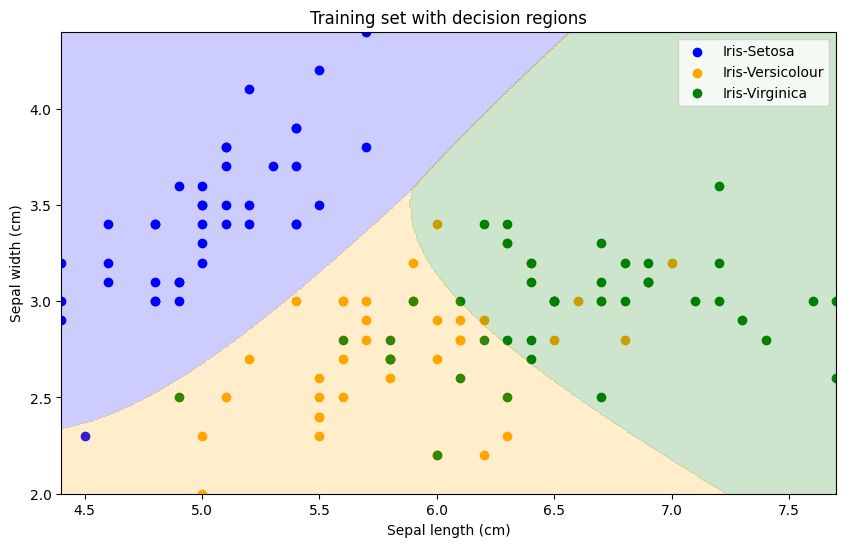

In [18]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: torch.log(predict_class(prior, class_conditionals, x)), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Binary classifiers

We will now draw a connection between the Naive Bayes classifier and logistic regression.

First, we will update our model to be a binary classifier. In particular, the model will output the probability that a given input data sample belongs to the 'Iris-Setosa' class: $P(Y=y_0 | \tilde{X}_1,\ldots,\tilde{X}_d)$. The remaining two classes will be pooled together with the label $y_1$.

In [19]:
y_train_binary = np.array(y_train)
y_train_binary[np.where(y_train_binary == 2)] = 1

y_test_binary = np.array(y_test)
y_test_binary[np.where(y_test_binary == 2)] = 1

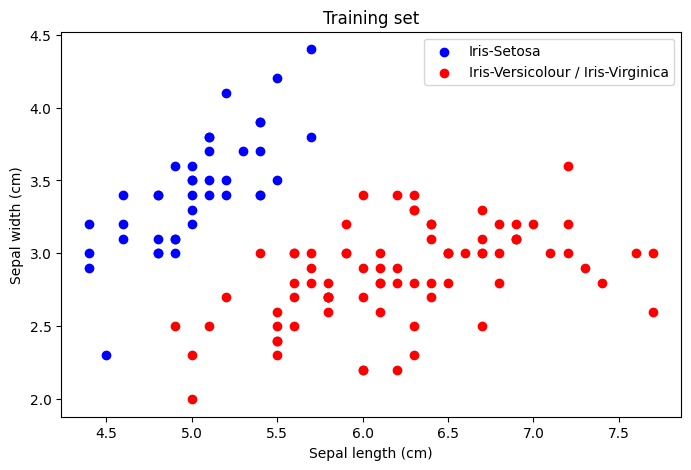

In [20]:
labels_binary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour / Iris-Virginica'}
label_colours_binary = ['blue', 'red']

plt.figure(figsize=(8, 5))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
plt.show()

In [21]:
prior_binary = get_prior(y_train_binary)

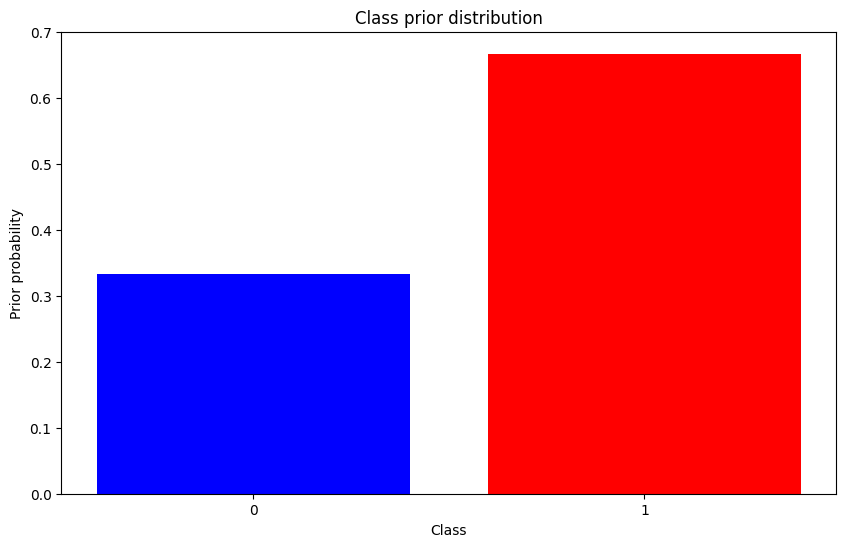

In [22]:
plt.bar([0, 1], prior_binary.probs.numpy(), color=label_colours_binary)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1], labels_binary)
plt.show()

In [23]:
class_conditionals_binary = get_class_conditionals(x_train, y_train_binary)

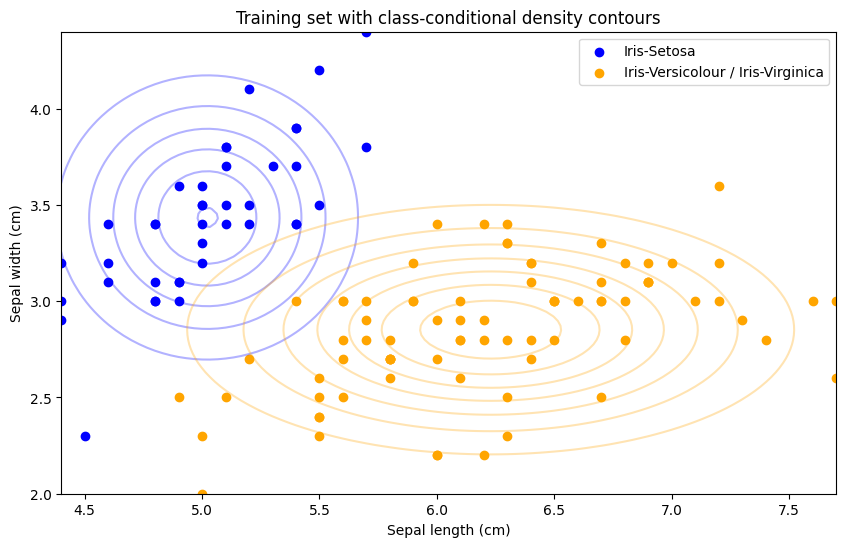

In [24]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals_binary.log_prob, 2, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

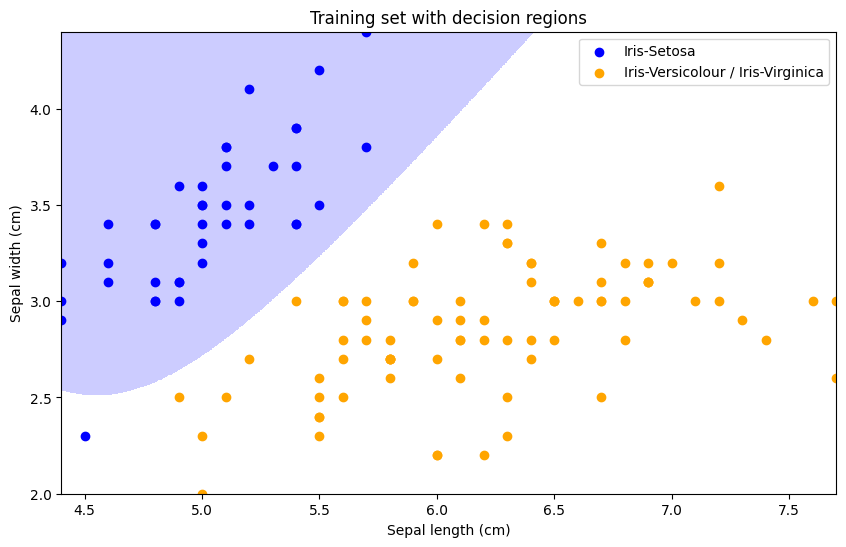

In [25]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: torch.log(predict_class(prior_binary, class_conditionals_binary, x)), 
             1, label_colours, levels=[-0.5, 0.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Logistic regression

Adapt the code provided for the linear regression in [Module 2 -dataflowr](https://dataflowr.github.io/website/modules/2b-automatic-differentiation/) to make a logistic regression.

In [26]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

epochs = 4000
input_dim = 2 # Two inputs x1 and x2 
output_dim = 1 
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
def train(model,criterion,optimizer,x_train,y_train,x_test,y_test,n_epochs=epochs,freq_print=200):
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    for epoch in range(n_epochs):
        outputs = model(x_train)
        
        loss = criterion(outputs.squeeze(), y_train) 
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        iter+=1
        if iter%freq_print==0:
            # calculate Accuracy
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = torch.squeeze(model(x_test))
                loss_test = criterion(outputs_test, y_test)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_test.size(0)
                correct_test += np.sum(predicted_test == y_test.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())
                
                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
    return losses, losses_test, Iterations

In [28]:
dtype = torch.float32
x_trt = torch.tensor(x_train, dtype=dtype)
x_tst = torch.tensor(x_test, dtype=dtype)
y_trt = torch.tensor(y_train_binary, dtype=dtype)
y_tst = torch.tensor(y_test_binary, dtype=dtype)

losses, losses_test, Iterations = train(model,criterion,optimizer,x_trt,y_trt,x_tst,y_tst)

Iteration: 200. 
Test - Loss: 0.48109278082847595. Accuracy: 66.66666666666667
Train -  Loss: 0.48868611454963684. Accuracy: 66.66666666666667

Iteration: 400. 
Test - Loss: 0.41620558500289917. Accuracy: 73.33333333333333
Train -  Loss: 0.4247933030128479. Accuracy: 78.33333333333333

Iteration: 600. 
Test - Loss: 0.3660053312778473. Accuracy: 93.33333333333333
Train -  Loss: 0.3758833110332489. Accuracy: 89.16666666666667

Iteration: 800. 
Test - Loss: 0.3264296352863312. Accuracy: 96.66666666666667
Train -  Loss: 0.3376731872558594. Accuracy: 92.5

Iteration: 1000. 
Test - Loss: 0.29462629556655884. Accuracy: 96.66666666666667
Train -  Loss: 0.3071973919868469. Accuracy: 96.66666666666667

Iteration: 1200. 
Test - Loss: 0.2686068117618561. Accuracy: 96.66666666666667
Train -  Loss: 0.28241628408432007. Accuracy: 98.33333333333333

Iteration: 1400. 
Test - Loss: 0.2469724863767624. Accuracy: 96.66666666666667
Train -  Loss: 0.2619127333164215. Accuracy: 99.16666666666667

Iteration: 

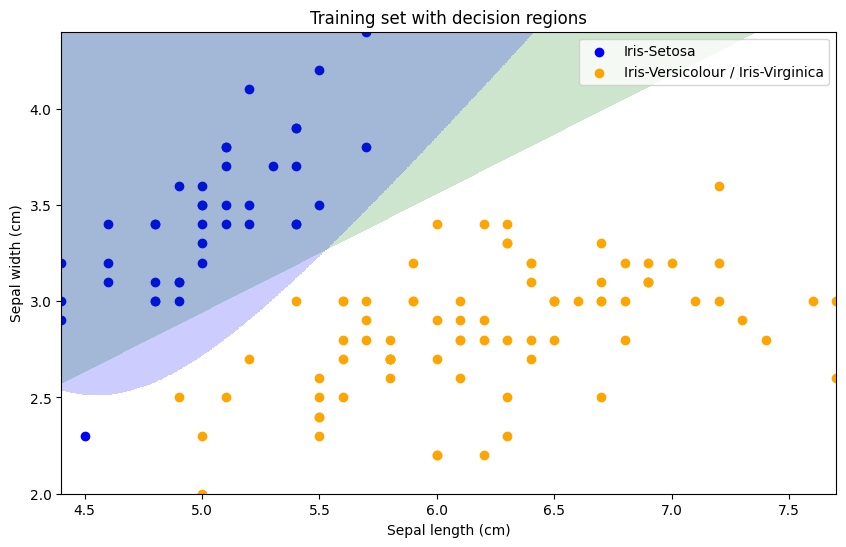

In [29]:
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
model.eval()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: torch.log(model(x)), 
             1, ['green'], levels=[-0.5, 0.5],
             num_points=500)
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: torch.log(predict_class(prior_binary, class_conditionals_binary, x)), 
             1, label_colours, levels=[-0.5, 0.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Find the link between Naive Bayes and Logistic regression

It looks like the decision boundaries are not the same for these classifiers. Find the condition you need to enforce for Naive Bayes to get the same decision boundaries (hint: have a look at the contour plots above). Check your condition by doing the math!